In [1]:
import jax.numpy as jnp
import numpy as np
from jax import grad, jit, vmap, lax
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

from math import sqrt
import threading

In [2]:
#@title Define helper functions
#@markdown JAX requires code to be purely functional, with no opbject oriented
#@markdown programming. 
# Gives time of closest approach
def closest(pit, pos0, vel):
    vx, vy = vel
    px, py = pit
    x0, y0 = pos0

    temp = 2 * vx * px - 2 * vx * x0 \
         + 2 * vy * py - 2 * vy * y0

    temp2 = 2 * vx * vx + 2 * vy * vy

    # Returns 0 if ball isn't moving or is moving away from the pit
    return lax.cond(temp2 == 0 or temp < 0, lambda x,y : 0.0, lambda x, y: x/y, temp, temp2)

def dist_sq(pit, pos0, vel, t):
    vx, vy = vel
    px, py = pit
    x0, y0 = pos0

    x_dist = px - (x0 + vx*t)
    y_dist = py - (y0 + vy*t)

    return x_dist**2 + y_dist**2

def dist(pit, pos0, vel, t):
    d_sq = dist_sq(pit, pos0, vel, t)
    return lax.sqrt(d_sq)

def min_dist_sq(pit, pos, vel):
    t = closest(pit, pos, vel)
    return dist_sq(pit, pos, vel, t)

def min_dist(pit, pos, vel):
    t = closest(pit, pos, vel)
    return dist(pit, pos, vel, t)


In [6]:
#@markdown This cell can be skipped, it's only to test the above functions

pit = (80., 75.)
pos0 = (0.,0.)
vel = (1.,1.)

print(f"Minimum distance {min_dist(pit, pos0, vel)}"
        f" is reached at time {closest(pit, pos0, vel)}")

Minimum distance 3.535533905029297 is reached at time 77.5


In [3]:
#@title Gradient Descent
# Use jax to get a gradient for min_dist, w.r.t. vel

d_min_dist_sq = grad(min_dist_sq, argnums=2)
d_min_dist = grad(min_dist, argnums=2)

# Parameters: initial conditions, and learning parameters
# r: ball radius: if this distance from the pit is reached, the ball is in
# lr: learning rate
# mf: momentum factor
def grad_descent(pit, pos0, vel, r, lr = 0.001, mf = 0.8):
    passes = 0
    g_old = d_min_dist(pit, pos0, vel)
    while True:
        g = d_min_dist(pit, pos0, vel)
        delta = (g[0] * (1-mf) + g_old[0] * mf, g[1] * (1-mf) + g_old[1] * mf)

        g_old = delta

        vx, vy = vel
        vx -= delta[0] * lr
        vy -= delta[1] * lr
        vel = (vx, vy)

        d = min_dist(pit, pos0, vel)
        passes += 1
        print(f"Pass {passes}, dist: {d}")

        if d < ball_radius:
            print(f"Ball reached target after {passes} passes")
            return passes
        if passes == 75:
            print(f"Giving up after {passes} passes, closest was {d}")
            return passes

In [ ]:
#@title Run experiments
# Perform gradient descent
pit = (80., 75.)
pos0 = (0.,0.)
vel = (0.,1.)
ball_radius = 0.5


# To smoothen out heuristic space, multiple pits are tested:
pits = ((80., 75.), (20, 99), (69, 60), (50, 50), (100, 1))

# Learning rates and momentum factors to test
lrs = (0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.0055, 0.006, 0.0065, 0.007, 0.0075, 0.008)
mfs = (0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9)

results = np.zeros((len(lrs), len(mfs), len(pits)))
threads = []

# Wrapper for multithreading
class myThread(threading.Thread):
    def __init__(self, i, j, p):
        threading.Thread.__init__(self)
        self.i = i
        self.j = j
        self.p = p

    def run(self):
        r = grad_descent(pits[self.p], pos0, vel,\
                         ball_radius, lrs[self.i], mfs[self.j])
        results[self.i, self.j, self.p] = r

def run_one_grad(pit, pos0, vel, r, lr, mf, i, j):
    results[i,j] = grad_descent(pit, pos0, vel, r, lr, mf)

# Start every experiment on a separate thread
for i in range(len(lrs)):
    line = []
    for j in range(len(mfs)):
        for p in range(len(pits)):
            t = myThread(i,j,p)
            t.start()
            threads.append(t)

# Wait for threads to finish
for t in threads:
    t.join()

print(results)
results = np.mean(results, axis=2)

print(results)

Pass 1, dist: 64.80813598632812Pass 1, dist: 64.80813598632812
Pass 1, dist: 67.9893798828125

Pass 1, dist: 4.370623588562012
Pass 1, dist: 99.99718475341797
Pass 1, dist: 4.370623588562012
Pass 1, dist: 61.35979080200195
Pass 1, dist: 44.77667236328125
Pass 1, dist: 67.9893798828125
Pass 1, dist: 44.77667236328125
Pass 1, dist: 43.41215896606445
Pass 1, dist: 99.99779510498047
Pass 1, dist: 67.9893798828125
Pass 1, dist: 64.80813598632812
Pass 1, dist: 0.39041879773139954
Ball reached target after 1 passes
Pass 1, dist: 59.336185455322266
Pass 1, dist: 0.39041879773139954
Ball reached target after 1 passes
Pass 1, dist: 43.41215896606445
Pass 1, dist: 61.35979080200195
Pass 1, dist: 59.336185455322266Pass 1, dist: 67.9893798828125
Pass 1, dist: 0.39041879773139954
Ball reached target after 1 passes
Pass 1, dist: 99.99779510498047Pass 1, dist: 67.9893798828125

Pass 1, dist: 44.77667236328125
Pass 1, dist: 4.370623588562012
Pass 1, dist: 61.35979080200195
Pass 1, dist: 61.359790802001

In [19]:
#@title Precalculated results
#@markdown The code in this block can be used to skip running the experiments,
#@markdown which can be a lengthy process. \
#@markdown This block is commented out so that it does not cause problems if all cells are run

# Read results into an array without recalculating everything

# lrs = (0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.0055, 0.006, 0.0065, 0.007, 0.0075, 0.008)
# mfs = (0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9)

# results = np.array([[34.85714286, 29.28571429, 45.85714286, 42.57142857, 32.28571429, 30.
# ,  22.,  14.85714286, 22.85714286, 29.57142857]
# , [34.57142857, 38.42857143, 26.42857143, 45.57142857, 35.14285714, 25.71428571
# ,  23.,  15.57142857, 23.71428571, 41.42857143]
# , [29.28571429, 37.,  35.71428571, 36.71428571, 38.71428571, 15.57142857
# ,  16.57142857, 17.42857143, 24.42857143, 33.28571429]
# , [29.28571429, 40.85714286, 40.,  23.42857143, 29.42857143, 18.42857143
# ,  29.85714286, 29.42857143, 23.85714286, 34.57142857]
# , [48.28571429, 36.14285714, 26.14285714, 21.,  11.71428571, 38.85714286
# ,  15.85714286, 27.71428571, 19.28571429, 41.14285714]
# , [25.42857143, 18.14285714, 27.,  53.85714286, 26.57142857, 24.85714286
# ,  24.14285714, 14.14285714, 21.42857143, 31.42857143]
# , [13.14285714, 19.28571429, 23.28571429, 32.28571429, 49.,  31.57142857
# ,  17.71428571, 21.,  22.,  40.42857143]
# , [20.14285714, 24.85714286, 39.71428571, 41.14285714, 28.28571429, 35.85714286
# ,  37.57142857, 25.14285714, 25.14285714, 44.14285714]
# , [26.85714286, 15.42857143, 23.42857143, 34.57142857, 44.14285714, 24.42857143
# ,  29.57142857, 23.71428571, 17.57142857, 39.14285714]
# , [11.28571429, 20.42857143, 15.,  47.57142857, 27.71428571, 17.85714286
# ,  30.85714286, 21.,  20.42857143, 35.28571429]
# , [20.57142857, 34.71428571, 21.42857143, 35.85714286, 33.28571429, 40.71428571
# ,  33.,  19.42857143, 28.57142857, 38.71428571]
# , [18.85714286, 13.14285714, 14.,  43.14285714, 16.,  18.57142857
# ,  18.57142857, 15.,  25.14285714, 41.42857143]
# , [12.71428571, 20.71428571, 34.,  25.71428571, 20.71428571, 26.
# ,  21.42857143, 15.28571429, 26.42857143, 41.57142857]])

# Narrowed range
# lrs = (0.0065, 0.007, 0.0075, 0.008, 0.0085, 0.009, 0.0095, 0.01)
# mfs = (0.0, 0.1, 0.2, 0.3)

# results = np.array(
# [[11.28571429, 20.42857143, 15., 47.57142857]
# , [20.57142857, 34.71428571, 21.42857143, 35.85714286]
# , [18.85714286, 13.14285714, 14., 43.14285714]
# , [12.71428571, 20.71428571, 34., 25.71428571]
# , [10.71428571, 12.71428571, 24.57142857, 30.14285714]
# , [17.42857143, 21.57142857, 35.57142857, 33.28571429]
# , [19.71428571, 37.71428571, 25.14285714, 22.57142857]
# , [26.57142857, 39.28571429, 22.85714286, 14.42857143]])

# print(results)

[[34.85714286 29.28571429 45.85714286 42.57142857 32.28571429 30.
  22.         14.85714286 22.85714286 29.57142857]
 [34.57142857 38.42857143 26.42857143 45.57142857 35.14285714 25.71428571
  23.         15.57142857 23.71428571 41.42857143]
 [29.28571429 37.         35.71428571 36.71428571 38.71428571 15.57142857
  16.57142857 17.42857143 24.42857143 33.28571429]
 [29.28571429 40.85714286 40.         23.42857143 29.42857143 18.42857143
  29.85714286 29.42857143 23.85714286 34.57142857]
 [48.28571429 36.14285714 26.14285714 21.         11.71428571 38.85714286
  15.85714286 27.71428571 19.28571429 41.14285714]
 [25.42857143 18.14285714 27.         53.85714286 26.57142857 24.85714286
  24.14285714 14.14285714 21.42857143 31.42857143]
 [13.14285714 19.28571429 23.28571429 32.28571429 49.         31.57142857
  17.71428571 21.         22.         40.42857143]
 [20.14285714 24.85714286 39.71428571 41.14285714 28.28571429 35.85714286
  37.57142857 25.14285714 25.14285714 44.14285714]
 [26.857

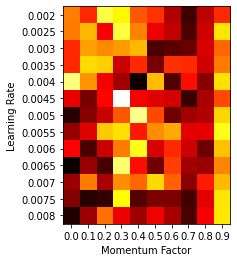

In [20]:
fig, ax = plt.subplots()
p = plt.imshow(results, cmap='hot', interpolation='nearest')

x_ticks = [float(x) for x in range(len(mfs))]
ax.set_xlabel("Momentum Factor")
ax.set_ylabel("Learning Rate")
ax.set_xticks(x_ticks)
ax.set_xticklabels(mfs)

y_ticks = [float(x) for x in range(len(lrs))]
ax.set_yticks(y_ticks)
ax.set_yticklabels(lrs)

# plt.show()
plt.savefig("minigolf_hmap_2.png")

In [ ]:
m = np.min(results)
print(m)

10.71428571


In [14]:
def gauss1d(sigma, filter_length=11):
    # INPUTS
    # @ sigma         : sigma of gaussian distribution
    # @ filter_length : integer denoting the filter length
    # OUTPUTS
    # @ gauss_filter  : 1D gaussian filter without normalization

    rng = range(-int(filter_length/2),int(filter_length/2)+1)
    gauss_filter = [np.exp((-x**2) / (2*sigma**2)) for x in rng]

    # The formula used above has been given in the instruction.
    return np.array(gauss_filter)

g1 = gauss1d(1, 5).reshape((5,1))
g1_t = np.transpose(g1)
g2 = np.matmul(g1, g1_t)
g2 = g2 / np.sum(g2)
print(g2)


[[0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.02193823 0.09832033 0.16210282 0.09832033 0.02193823]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]]


[[17.53741443 20.61260351 26.60468548 34.71254383]
 [19.25882988 21.59332549 26.40773914 33.06984768]
 [18.26895119 20.56597962 25.49206599 31.19480627]
 [16.04286649 19.58544385 25.23029917 29.5048215 ]
 [15.93293639 20.17617273 25.8791765  29.1444301 ]
 [19.58938104 23.49549738 27.23316788 28.56135858]
 [24.68877139 27.27480405 26.93891385 24.83462553]
 [28.16609315 29.30802094 25.65198161 20.87101673]]
15.932936391475046


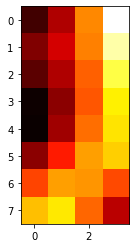

In [15]:
smooth_results = convolve(results, g2)
print(smooth_results)
print(np.min(smooth_results))

plt.imshow(smooth_results, cmap='hot', interpolation='nearest')
plt.show()